<a href="https://colab.research.google.com/github/khushbooG9/Pointer-Networks-Using-Fast-Weights/blob/master/FW_PointerNets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf 
from tensorflow.keras.layers import LSTM
import matplotlib.pyplot as plt
#import tensorflow.contrib.eager as tfe
import numpy as np 
tf.enable_eager_execution()

In [0]:
class Encoder(tf.keras.Model):
	def __init__(self, hidden_size=512):
		super(Encoder, self).__init__()
		self.encoder = LSTM(hidden_size, return_sequence = True, return_state = True)

	def call(self, x):
		e, state_h, state_c  = self.encoder(x)        
		return e, [state_h, state_c]

class Decoder(tf.keras.Model):
	def __init__(self, hidden_size=512):
		super(Decoder, self).__init__()
		self.decoder = LSTM(hidden_size, return_sequence = True, return_state = True)

	def call(self, x, hidden_states):
		d, state_h, state_c  = self.decoder(x, initial_state=hidden_states)
		return d, [state_h, state_c]

class PtrnetLSTM(tf.keras.Model):
	def __init__(self, hidden_size=512):
		super(PtrnetLSTM, self).__init__()
		#self.W1 = tfe.variable(tf.random_uniform([hidden_size, hidden_size], -0.08, 0.08), dtype=float32)
		self.W1 = tf.keras.layers.Dense(hidden_size, kernel_initializer= tf.keras.initializers.RandomUniform(minval = -0.08, maxval = 0.08, seed = None), use_bias=False)
		self.W2 = tf.keras.layers.Dense(hidden_size, kernel_initializer= tf.keras.initializers.RandomUniform(minval = -0.08, maxval = 0.08, seed = None), use_bias=False)
		#Dense layer -> dot(input, kernel) -> so now Ui = vT . tanh(W1 . e + W2 . di)  becomes Ui = tanh(e . W1 + di . W2) . v
		self.VT = tf.keras.layers.Dense(1, use_bias=False)
	# e= encoder output and d = decoder output
	def call(self, e,d):
		u = self.VT(tf.nn.tanh(self.W1(e) + self.W2(d)))
		attention = tf.nn.softmax(u, axis = 1)

		return tf.reshape(attention, attention.shape[0], attention.shape[1])


In [0]:

class fastweights(tf.keras.Model):
	def __init__(self, input_dim, elemnum , batch_size=128, decay_rate = 0.9, learning_rate = 0.5, hidden_size=512):
		super(fastweights, self).__init__()
		self.batch_size = batch_size
		self.DR = decay_rate
		self.LR = learning_rate
		self.hidden_size = hidden_size
		self.W_x = tf.Variable(tf.random_uniform([elemnum, hidden_size], -np.sqrt(2/elemnum), np.sqrt(2/elemnum)), dtype=tf.float32)
		self.B_x = tf.Variable(tf.zeros(hidden_size), dtype=tf.float32)
		self.W_h = tf.Variable(initial_value = 0.5 * np.identity(hidden_size), dtype = tf.float32)
		self.W_y = tf.Variable(tf.random_uniform([hidden_size, elemnum], -np.sqrt(2/hidden_size), np.sqrt(2/hidden_size)), dtype = tf.float32)
		self.B_y = tf.Variable(tf.zeros(elemnum), dtype= tf.float32)
		self.scale = tf.Variable(tf.ones(hidden_size), dtype = tf.float32)
		self.shift = tf.Variable(tf.zeros(hidden_size), dtype = tf.float32) 
		#initial values of A and H matricies
		self.A = tf.zeros([self.batch_size, self.hidden_size,self.hidden_size], dtype = tf.float32)
		self.H = tf.zeros([self.batch_size, self.hidden_size], dtype = tf.float32)
    
	def call(self,X, Y, S=1):
		X = tf.cast(X, tf.float32)
		for t in range(tf.shape(X)[1]):
			#first hidden state, A and H_s are  zero at this point so the part A(t)H_s(t+1) becomes zero
			self.H = tf.nn.relu((tf.matmul(self.H,self.W_h))+(tf.matmul(X[:, t, :],self.W_x)+self.B_x))
			#reshaping to use it with A, to calculate the A(t)H_s(t+1)
			H_s = tf.reshape(self.H, [self.batch_size, 1, self.hidden_size])
			#Initial A for this particular time step: A(t) = decay*A(t-1)+ learning*h(t)h(t).T
			#self.A = tf.add((tf.scalar_mul(self.DR, self.A)),(tf.batch_matmul(tf.transpose(self.H_s, [0,2,1]),self.H_s)))
			self.A = (tf.scalar_mul(self.DR, self.A))+ tf.scalar_mul(self.LR,(tf.matmul(tf.transpose(H_s, [0,2,1]),H_s)))
			#inner loop for fast weights, tfor S steps
			for _ in range(S):
				#calculating H_s without the non linearity first, so we can use linear normalization 
				H_s = tf.reshape(tf.matmul(self.H,self.W_h),tf.shape(H_s)) + tf.reshape(tf.matmul(X[:,t,:],self.W_x)+self.B_x,tf.shape(H_s)) + tf.matmul(H_s, self.A)
				#Applying Layer Normalization 
				mean, var = tf.nn.moments(H_s, axes =2, keep_dims = True)
				H_s = (self.scale*(H_s - mean))/(tf.sqrt(var + 1e-5) + self.shift)
				#applying non linearity
				H_s = tf.nn.relu(H_s)
			self.H = tf.reshape(H_s,[self.batch_size, self.hidden_size])
		finallayer = tf.matmul(self.H, self.W_y) + self.B_y
		return finallayer

In [0]:
"""
class fastweights(object):
  def __init__(self, inputt, target, batch_size=128, decay_rate = 0.9, learning_rate = 0.5, hidden_size=512):
    super(fastweights, self).__init__()
    self.X = inputt
    self.Y = target
    self.Y_size = tf.shape(target)[0]
    self.batch_size = batch_size
    self.DR = decay_rate
    self.LR = learning_rate
    self.hidden_size = hidden_size
    self.W_x = tfe.Variable(tf.random_uniform([tf.shape(inputt)[1], hidden_size], -np.sqrt(2/tf.shape(inputt)[1]), np.sqrt(2/tf.shape(inputt)[1])), dtype=float32)
    self.B_x = tfe.Variable(tf.zeros(hidden_size), dtype=float32)
    self.W_h = tfe.Variable(initial_value = 0.5 * np.identity(hidden_size), dtype = float32)
    self.W_y = tfe.Variable(tf.random_uniform([hidden_size, output_size], -np.sqrt(2/hidden_size), np.sqrt(2/hidden_size)), dtype = float32)
    self.B_y = tfe.Variable(tf.zeros(output_size), dtype=float32)
    self.scale = tfe.Variable(tf.ones(hidden_size), dtype =float32)
    self.shift = tfe.Variable(tf.zeros(hidden_size), dtype = float32) 
    #initial values of A and H matricies
    self.A = tf.zeros([self.batch_size, self.hidden_size,self.hidden_size], dtype = float32)
    self.H = tf.zeros([self.batch_size, self.hidden_size], dtype = float32)
    
  def call(self,S=1):
    
    for t in range(self.X.shape[1]):
			#first hidden state, A and H_s are  zero at this point so the part A(t)H_s(t+1) becomes zero
      self.H = tf.nn.relu((tf.matmul(self.H,self.W_h))+(tf.matmul(self.X[:, t, :],self.W_x)+self.B_x))
			#reshaping to use it with A, to calculate the A(t)H_s(t+1)
      H_s = tf.reshape(self.H, [self.batch_size, 1, self.hidden_size])
			#Initial A for this particular time step: A(t) = decay*A(t-1)+ learning*h(t)h(t).T
			#self.A = tf.add((tf.scalar_mul(self.DR, self.A)),(tf.batch_matmul(tf.transpose(self.H_s, [0,2,1]),self.H_s)))
      self.A = (tf.scalar_mul(self.DR, self.A))+ tf.scalar_mul(self.LR,(tf.batch_matmul(tf.transpose(H_s, [0,2,1]),H_s)))
			#inner loop for fast weights, tfor S steps
      for _ in range(S):
				#calculating H_s without the non linearity first, so we can use linear normalization 
        H_s = tf.reshape(tf.matmul(self.H,self.W_h),tf.shape(H_s)) + tf.reshape(tf.matmul(self.X[:,t,:],self.W_x)+self.B_x,tf.shape(H_s)) + tf.batch_matmul(H_s, self.A)
				#Applying Layer Normalization 
        mean, var = tf.nn.moments(H_s, axes =2, keep_dims = True)
        H_s = (self.scale*(H_s - mean))/(tf.sqrt(var + 1e-5) + self.shift)
				#applying non linearity
        H_s = tf.nn.relu(H_s)
      self.H = tf.reshape(H_s,[self.batch_size, self.hidden_size])
    finallayer = tf.matmul(self.H, self.W_y) + self.B_y
    #self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(finallayer, self.Y))
    #self.trainable_vars = tf.trainable_variables()
    #self.lr = tfe.Variable(0.0, trainable = False)
    #self.grads, self.norm = tf.clip_by_global_norm(tf.gradients(self.loss, self.trainable_vars), 5.0 )
    #optimizer = tf.train.AdamOptimizer(self.lr)
    #self.update = optimizer.apply_gradients(zip(self.grads, self.trainable_vars))

    return finallayer
    
   """ 

'\nclass fastweights(object):\n  def __init__(self, inputt, target, batch_size=128, decay_rate = 0.9, learning_rate = 0.5, hidden_size=512):\n    super(fastweights, self).__init__()\n    self.X = inputt\n    self.Y = target\n    self.Y_size = tf.shape(target)[0]\n    self.batch_size = batch_size\n    self.DR = decay_rate\n    self.LR = learning_rate\n    self.hidden_size = hidden_size\n    self.W_x = tfe.Variable(tf.random_uniform([tf.shape(inputt)[1], hidden_size], -np.sqrt(2/tf.shape(inputt)[1]), np.sqrt(2/tf.shape(inputt)[1])), dtype=float32)\n    self.B_x = tfe.Variable(tf.zeros(hidden_size), dtype=float32)\n    self.W_h = tfe.Variable(initial_value = 0.5 * np.identity(hidden_size), dtype = float32)\n    self.W_y = tfe.Variable(tf.random_uniform([hidden_size, output_size], -np.sqrt(2/hidden_size), np.sqrt(2/hidden_size)), dtype = float32)\n    self.B_y = tfe.Variable(tf.zeros(output_size), dtype=float32)\n    self.scale = tfe.Variable(tf.ones(hidden_size), dtype =float32)\n    self

In [0]:
import random
"""
    Creating the data set for fast weights implementation.
    Data will minmic the synthetic dataset created in
    https://arxiv.org/abs/1610.06258 Ba et al.
    Ex.
    c6a7s4??a = 7 (it asking for the value for the key a)
    This is a very interesting dataset because
    it requires the model to retrieve and use temporary memory
    in order to accurately predict the proper value for the key.
"""

def get_three_letters():
    """
    Retrieve three random letters (a-z)
    without replacement.
    """
    return np.random.choice(range(0,26), 3, replace=False)

def get_three_numbers():
    """
    Retrieve three random numbers (0-9)
    with replacement.
    """
    return np.random.choice(range(26, 26+10), 3, replace=True)

def create_sequence():
    """
    Concatenate keys and values with
    ?? and one of the keys.
    Returns the input and output.
    """
    letters = get_three_letters()
    numbers = get_three_numbers()
    X = np.zeros((9))
    y = np.zeros((1))
    for i in range(0, 5, 2):
        X[i] = letters[int(i/2)]
        X[i+1] = numbers[int(i/2)]

    # append ??
    X[6] = 26+10
    X[7] = 26+10

    # last key and respective value (y)
    index = np.random.choice(range(0,3), 1, replace=False)
    X[8] = letters[index]
    y = numbers[index]

    # one hot encode X and y
    X_one_hot = np.eye(26+10+1)[np.array(X).astype('int')]
    y_one_hot = np.eye(26+10+1)[y][0]

    return X_one_hot, y_one_hot

def ordinal_to_alpha(sequence):
    """
    Convert from ordinal to alpha-numeric representations.
    Just for funsies :)
    """
    corpus = ['a','b','c','d','e','f','g','h','i','j','k','l',
              'm','n','o','p','q','r','s','t','u','v','w','x','y','z',
               0, 1, 2, 3, 4, 5, 6, 7, 8, 9, '?']

    conversion = ""
    for item in sequence:
        conversion += str(corpus[int(item)])
    return conversion

def create_data(num_samples):
    """
    Create a num_samples long set of X and y.
    """
    X = np.zeros([num_samples, 9, 26+10+1], dtype=np.int32)
    y = np.zeros([num_samples, 26+10+1], dtype=np.int32)
    for i in range(num_samples):
        X[i], y[i] = create_sequence()
    return X, y

def generate_epoch(X, y, num_epochs, batch_size):

    for epoch_num in range(num_epochs):
        yield generate_batch(X, y, batch_size)

def generate_batch(X, y, batch_size):

    data_size = len(X)

    num_batches = (data_size // batch_size)
    for batch_num in range(num_batches):
        start_index = batch_num * batch_size
        end_index = min((batch_num + 1) * batch_size, data_size)
        yield X[start_index:end_index], y[start_index:end_index]

# Sampling
sample_X, sample_y = create_sequence()
print ("Sample:", ordinal_to_alpha([np.argmax(X) for X in sample_X]), ordinal_to_alpha([np.argmax(sample_y)]))
# Train/valid sets
train_X, train_y = create_data(640)
print ("train_X:", np.shape(train_X), ",train_y:", np.shape(train_y))
valid_X, valid_y = create_data(384)
print ("valid_X:", np.shape(valid_X), ",valid_y:", np.shape(valid_y))
test_X, test_y = create_data(384)
print ("test_X:", np.shape(test_X), ",test_y:", np.shape(test_y))
    

Sample: r0j0q7??q 7
train_X: (640, 9, 37) ,train_y: (640, 37)
valid_X: (384, 9, 37) ,valid_y: (384, 37)
test_X: (384, 9, 37) ,test_y: (384, 37)


In [0]:
lr = tf.Variable(0.0, trainable = False)
optimizer = tf.train.AdamOptimizer(0.1)
inputdim = 9
elem = 37
fw = fastweights(inputdim, elem, 128, 0.9, 0.5, 512)
checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=fw)

In [0]:
t_loss_history = []
  
for train_epoch_num, train_epoch in enumerate(generate_epoch(train_X, train_y, 500, 128)):
  print("Epoch number :", train_epoch_num)
  for train_batch_num, (batch_X, batch_y) in enumerate(train_epoch):
    loss = 0

    with tf.GradientTape() as tape:
      pred_y = fw(batch_X, batch_y, 1)
      loss += tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=pred_y, labels= batch_y))
        
      batch_loss = (loss/128)
      if train_batch_num %10 ==0:
        print("\tEpoch {:03d}/{:03d}: Loss at step {:02d}: {:.9f}".format((train_epoch_num+1), 1000, train_batch_num, tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=pred_y, labels= batch_y)) ))
  t_loss_history.append(batch_loss.numpy())
  variables = fw.variables
  grads, norm =tf.clip_by_global_norm(tape.gradient(loss, variables), 0.25) 
  optimizer.apply_gradients(zip(grads, variables), global_step=tf.train.get_or_create_global_step())
  print("Epoch {:03d}/{:03d} completed \t - \tBatch loss: {:.9f}".format((train_epoch_num+1), 1000, tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=pred_y, labels= batch_y)) ))
#tf.contrib.eager.Saver(variables).save('trained.ckpt')
checkpoint.save('trained.ckpt')
print("Final loss for training  set: {:.9f}".format(tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=pred_y, labels= batch_y))))

Epoch number : 0
	Epoch 001/1000: Loss at step 00: 3.716274738
Epoch 001/1000 completed 	 - 	Batch loss: 3.772774696
Epoch number : 1
	Epoch 002/1000: Loss at step 00: 8.082309723
Epoch 002/1000 completed 	 - 	Batch loss: 5.683158398
Epoch number : 2
	Epoch 003/1000: Loss at step 00: 14.983819962
Epoch 003/1000 completed 	 - 	Batch loss: 13.865386009
Epoch number : 3
	Epoch 004/1000: Loss at step 00: 17.785694122
Epoch 004/1000 completed 	 - 	Batch loss: 17.812538147
Epoch number : 4
	Epoch 005/1000: Loss at step 00: 20.212806702
Epoch 005/1000 completed 	 - 	Batch loss: 21.590166092
Epoch number : 5
	Epoch 006/1000: Loss at step 00: 20.335016251
Epoch 006/1000 completed 	 - 	Batch loss: 22.970752716
Epoch number : 6
	Epoch 007/1000: Loss at step 00: 15.158548355
Epoch 007/1000 completed 	 - 	Batch loss: 16.994529724
Epoch number : 7
	Epoch 008/1000: Loss at step 00: 15.013202667
Epoch 008/1000 completed 	 - 	Batch loss: 15.379113197
Epoch number : 8
	Epoch 009/1000: Loss at step 00: 1

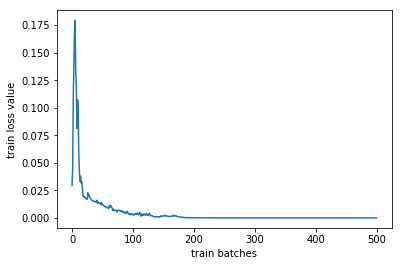

In [0]:
plt.plot(t_loss_history)

plt.ylabel('train loss value')
plt.xlabel('train batches')

plt.show()

In [0]:
test_loss = []
for train_epoch_num, train_epoch in enumerate(generate_epoch(train_X, train_y, 1, 128)):
  for train_batch_num, (batch_X, batch_y) in enumerate(train_epoch):
    loss = 0
    p = fw(batch_X, batch_y)
    loss += tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=p, labels= batch_y))
    bloss = (loss/128)
  test_loss.append(bloss)

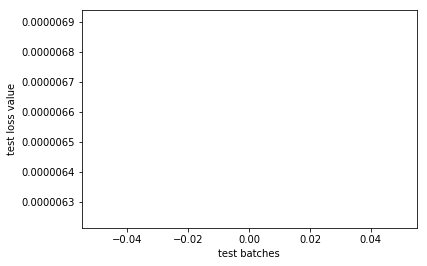

[<tf.Tensor: id=4942641, shape=(), dtype=float32, numpy=6.5760664e-06>]


In [0]:
plt.plot(test_loss)

plt.ylabel('test loss value')
plt.xlabel('test batches')

plt.show()

print(test_loss)